In [1]:
#%matplotlib inline

# %load_ext autoreload
# %autoreload 2

import time
import os
import pandas as pd
#from functools import wraps
from copy import deepcopy
import dill
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import itertools
import pickle
from pypalettes import get_hex
#from tqdm.autonotebook import tqdm, trange

# from IPython.display import display
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets


# torch packages
import torch
import torch.optim as optim
import torch.nn as nn

from torch.nn.functional import mse_loss
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets,transforms
from torchvision.transforms import v2
#from torchvision.utils import make_grid
from torchsummary import summary


#import torch.nn.functional as F 

FILENAME = 'LSTM_final_'

if '../src/modules/' not in sys.path:
    sys.path.append('../src/modules/')

from plot_jupyter import contour_compare, contour_data
from data_wrangle import get_days_before, get_test_set, window_mean, get_days_after
from sic_data_functions import get_ice_data, thin_data, iiee_calc, normalise_image, test_data_stats, thousands,millions, get_climate_avg, get_climate_avg_img, multiple_dfs_to_excel
from lstm_models import lstm_latent_3
from lstm_helpers import SlideWindowDataset
from autoenc_highres import Encoder_sharp_1024, Decoder_sharp_1024

batched_iiee = torch.func.vmap(iiee_calc)
batched_min = torch.func.vmap(torch.min)
batched_max = torch.func.vmap(torch.max)

formatter_mil = FuncFormatter(millions)

In [2]:
#seed for repeatable results
torch.manual_seed(0)

gen1 = torch.Generator().manual_seed(0)

run_climate_avg_on_latent = True
climate_window = 2  #[2,5,7,10,15,20]

run_img_climate_avg = False
img_window = 2

latent_dataset_dir = r'../inputs/'

ext_model_enc = r'../outputs/final/enc_sharp_64_1291_optimal_20240818'
ext_model_dec = r'../outputs/final/dec_sharp_64_1291_optimal_20240818'
ext_model_dec_imgnoise = r'../outputs/final/img_avg_dec_sharp_64_1289_optimal_20240823'

stats_dir = r'../outputs/stats/'

In [3]:
imported_enc, imported_dec = Encoder_sharp_1024, Decoder_sharp_1024 

with open(ext_model_enc, 'rb') as f:
    loaded_enc = torch.load(f)

if run_img_climate_avg:
    with open(ext_model_dec_imgnoise, 'rb') as f:
        loaded_dec = torch.load(f)
else:
    with open(ext_model_dec, 'rb') as f:
        loaded_dec = torch.load(f)

loaded_enc.eval()
loaded_dec.eval()

# loaded_enc_cpu = loaded_enc.cpu()
# loaded_dec_cpu = loaded_dec.cpu()

loaded_enc.to("cuda")
loaded_dec.to("cuda")

Decoder_sharp_1024(
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=1024, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(64, 4, 4))
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(4, 4))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (9): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (10): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(4, 4))
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(1, 1))
    (14): ConvTranspose2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
    (15): ConvTranspose2d(8, 8, kernel_size=(5, 5), stride=(2, 2))


In [4]:
sic_data, m , x,y,Y_mean_month, Y_mean_week = get_ice_data(return_all = True)

del m, Y_mean_month, Y_mean_week

In [5]:
year = 32 # year within data set
day = 0 # day within year as the starting point 
window = 1 # window-averaging
num_year_data = 32 # number of years worth of data
T_train = 365 * num_year_data  # how many days worth of data needed
batchSize = 1200  #batch size for dataloader will vary PC to PC for LSTM it will impact accuracy
dim_latent = 64 
T_test = 180
sliding_window = 800
fwd_pred_days = 180

# train_split = int(num_year_data*0.8) * 365
# val_split = num_year_data *365 - train_split

latent_train_name = 'latent_win_{}_train'.format(window)
latent_test_name = 'latent_win_{}_test'.format(window)

# X0_ = get_days_before(sic_data, year, day, T_train+window-1) # get days from DATA
# X1_ = get_days_after(sic_data, year, day,T_test)

# if window > 1:
#     X0_ = window_mean(X0_, window = window, t = None) # compute window mean, 
#     X1_ = get_test_set(sic_data, year, day, window, T_test)
# X0_.shape, X1_.shape

with open(latent_dataset_dir + latent_train_name, "rb") as in_data:
    latent_train= pickle.load(in_data)

with open(latent_dataset_dir + latent_test_name, "rb") as in_data:
    latent_test = pickle.load(in_data)

In [6]:
""" Uncomment to run: BOPlstm reconstruction and sequential forecast: """

from pydmd import DMD, BOPDMD

pred_range = 180

#run_climate_avg_on_latent = True

if run_climate_avg_on_latent:
    climate_window = [2,5,7,10,15,20]
    windows = climate_window
elif run_img_climate_avg:
    img_window = [2,5,7,10,15,20]
    windows = img_window
else:
    windows = [1,5,10,20]
#windows = [1]

#num_prev_yrs = [2,5,7,10]
#num_prev_yrs = [2]

#svd_ranks = [3,4,5,6,7,8,9,10]
#svd_ranks = [3]

#dmd_latent_stats = []
lstm_avg_stat = []
lstm_MSE = []
lstm_MAE = []
lstm_IIEE = []
lstm_latent_recon = []
lstm_latent_fwd = []
lstm_pred_integral = []
lstm_true_integral = []
climate_avg_stat = []
climate_MSE = []
climate_MAE = []
climate_IIEE = []
climate_integral = []

latent_data = []

latent_recon_avg_mse_temp =  0
latent_test_avg_mse_temp = 0 

for w in windows:
    X0_ = get_days_before(sic_data, year, day, T_train+w-1) # get days from DATA
    X1_ = get_days_after(sic_data, year, day,T_test)
    
    if run_climate_avg_on_latent:
        latent_train_name = 'latent_win_{}_train'.format(1)
        latent_test_name = 'latent_win_{}_test'.format(1)
        lstm_path = '../outputs/final/final_models/lstm_climate_window_{}_64'.format(w)

        with open(latent_dataset_dir + latent_test_name, "rb") as in_data:
            latent_test = pickle.load(in_data)

    elif run_img_climate_avg:
        latent_train_name = 'latent_img_climate_win_{}_train'.format(w)
        lstm_path = '../outputs/final/final_models/lstm_img_climate_window_{}_64'.format(w)
        img_noise, img_mean = get_climate_avg_img(torch.Tensor(X0_),w)

    else:
        latent_train_name = 'latent_win_{}_train'.format(w)
        latent_test_name = 'latent_win_{}_test'.format(w)
        lstm_path = '../outputs/final/final_models/lstm_window_{}_64'.format(w)

        with open(latent_dataset_dir + latent_test_name, "rb") as in_data:
            latent_test = pickle.load(in_data)
        
        if w > 1:
            X0_ = window_mean(X0_, window = w, t = None) # compute window mean, 
            X1_ = get_test_set(sic_data, year, day, w, T_test)
    
    X0_.shape, X1_.shape

    with open(latent_dataset_dir + latent_train_name, "rb") as in_data:
        latent_train= pickle.load(in_data)

    loaded_lstm_enc = lstm_latent_3(dim_latent = dim_latent)

    with open(lstm_path, 'rb') as f:
        loaded_lstm_enc = torch.load(f)
    
    loaded_lstm_enc.to("cuda")
    loaded_lstm_enc.eval()


    if run_climate_avg_on_latent:
        latent_train_noise_raw, latent_train_noise, latent_train_mean, latent_train_max, latent_train_min = get_climate_avg(latent_train, w)
        
        latent_train_noise_raw = latent_train_noise_raw.to("cuda")
        latent_train_noise =  latent_train_noise.to("cuda")
        latent_train_mean = latent_train_mean.to("cuda")
        latent_train_max = latent_train_max.to("cuda")
        latent_train_min = latent_train_min.to("cuda")

        lstm_output = loaded_lstm_enc(latent_train_noise[None,-800:].to("cuda"), future = pred_range, device = "cuda")
        
        #need to reverse  temp_return_norm = (temp_return - temp_min) /(temp_max- temp_min)
        lstm_pred_noise = lstm_output[-180:]
        lstm_pred = ((lstm_pred_noise.squeeze() *(latent_train_max - latent_train_min)) + latent_train_min)+ latent_train_mean[:180]
        lstm_out_reshape = (lstm_output.squeeze()[-730:]).reshape(2,365,64)
        lstm_full_temp = ((lstm_out_reshape*(latent_train_max - latent_train_min)) + latent_train_min)+ latent_train_mean
        lstm_full = lstm_full_temp.reshape(365*2,64)

    elif run_img_climate_avg:
        lstm_output = loaded_lstm_enc(latent_train[None,-800:].to("cuda"), future = pred_range, device = "cuda")
        lstm_pred_noise = lstm_output[-180:] 
        lstm_pred = lstm_pred_noise 

    else:
        lstm_output = loaded_lstm_enc(latent_train[None,-800:].to("cuda"), future = pred_range, device = "cuda")
        lstm_pred = lstm_output[-180:]
        lstm_full= lstm_output.squeeze()
    
    if run_img_climate_avg:
        pred_dec = loaded_dec(lstm_pred.squeeze()).clamp(-1,1).squeeze().detach().cpu()  + img_mean[:180]
        mean_decoded = img_mean

        # save down decoded images
        with open(stats_dir + 'forecasted_images/c_img_avg_lstm_SIC_win_{}.pkl'.format(w), 'wb') as output:
            pickle.dump(pred_dec.numpy()[:180], output)
        
        with open(stats_dir + 'forecasted_images/c_img_avg_climate_SIC_win_{}.pkl'.format(w), 'wb') as output:
            pickle.dump(mean_decoded[:180], output)
        
    elif run_climate_avg_on_latent:
        pred_dec = loaded_dec(lstm_pred.squeeze()).clamp(0,1).squeeze().detach().cpu() 
        mean_decoded = loaded_dec(latent_train_mean).clamp(0,1).squeeze().detach().cpu() 

        with open(stats_dir + 'forecasted_images/c_latent_avg_lstm_SIC_win_{}.pkl'.format(w), 'wb') as output:
            pickle.dump(pred_dec.numpy()[:180], output)
        
        with open(stats_dir + 'forecasted_images/c_latent_avg_climate_SIC_win_{}.pkl'.format(w), 'wb') as output:
            pickle.dump(mean_decoded.numpy()[:180], output)
        
        latent_data.append([('latent_avg',w),latent_train.detach().cpu().numpy(), latent_test.detach().cpu().numpy(),  lstm_full.detach().cpu().numpy()])
    else:
        pred_dec = loaded_dec(lstm_pred.squeeze()).clamp(0,1).squeeze().detach().cpu() 
        
        with open(stats_dir + 'forecasted_images/lstm_SIC_win_{}.pkl'.format(w), 'wb') as output:
            pickle.dump(pred_dec.numpy()[:180], output)

        latent_data.append([('LSTM',w),latent_train.detach().cpu().numpy(), latent_test.detach().cpu().numpy(),  lstm_full.detach().cpu().numpy()])

    if not run_img_climate_avg:
        latent_test_mse_temp =   ((lstm_pred.squeeze().detach().cpu().numpy() - latent_test[:180].numpy())**2).sum(axis=(0))/lstm_pred.shape[0]
        latent_test_avg_mse_temp = latent_test_mse_temp.sum()/latent_test_mse_temp.shape[0]  

    mse_temp = ((pred_dec.numpy() - X1_)**2).sum(axis=(1,2))/(X1_.shape[2]**2)
    mae_temp = (np.abs(pred_dec.numpy() - X1_)).sum(axis=(1,2))/(X1_.shape[2]**2)
    iiee_temp = batched_iiee(torch.Tensor(pred_dec), torch.Tensor(X1_)).numpy() *(25**2)
    
    Integral_pred = np.trapz(np.trapz((pred_dec)[:180], x, axis = 2), y, axis = 1)
    Integral_true = np.trapz(np.trapz(X1_[:180], x, axis = 2), y, axis = 1)

    mse_avg_temp = mse_temp[:pred_range].sum()/pred_range
    mae_avg_temp = mae_temp[:pred_range].sum()/pred_range
    iiee_avg_temp = iiee_temp[:pred_range].sum()/pred_range

    temp_stats = [latent_recon_avg_mse_temp,latent_test_avg_mse_temp, mse_avg_temp, mae_avg_temp, iiee_avg_temp]

    if run_img_climate_avg or run_climate_avg_on_latent:
        c_mse_temp = ((mean_decoded.numpy()[:180] - X1_)**2).sum(axis=(1,2))/(X1_.shape[2]**2)
        c_mae_temp = (np.abs(mean_decoded.numpy()[:180] - X1_)).sum(axis=(1,2))/(X1_.shape[2]**2)
        c_iiee_temp = batched_iiee(torch.Tensor(mean_decoded[:180]), torch.Tensor(X1_)).numpy() *(25**2)
        c_Integral_pred = np.trapz(np.trapz((mean_decoded)[:180], x, axis = 2), y, axis = 1)

        c_mse_avg_temp = c_mse_temp[:pred_range].sum()/pred_range
        c_mae_avg_temp = c_mae_temp[:pred_range].sum()/pred_range
        c_iiee_avg_temp = c_iiee_temp[:pred_range].sum()/pred_range

        c_temp_stats = [c_mse_avg_temp, c_mae_avg_temp, c_iiee_avg_temp]
        
        climate_avg_stat.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([c_temp_stats])), axis = 1, ignore_index= True))
        climate_MSE.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([c_mse_temp])), axis = 1, ignore_index= True))
        climate_MAE.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([c_mae_temp])), axis = 1, ignore_index= True))
        climate_IIEE.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([c_iiee_temp])), axis = 1, ignore_index= True))
        climate_integral.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([c_Integral_pred])), axis = 1, ignore_index= True))

    lstm_pred_integral.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([Integral_pred])), axis = 1, ignore_index= True))
    lstm_true_integral.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([Integral_true])), axis = 1, ignore_index= True))
    lstm_avg_stat.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([temp_stats])), axis = 1, ignore_index= True))
    lstm_MSE.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([mse_temp[:pred_range]])), axis = 1, ignore_index= True))
    lstm_MAE.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([mae_temp[:pred_range]])), axis = 1, ignore_index= True))
    lstm_IIEE.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([iiee_temp[:pred_range]])), axis = 1, ignore_index= True))
    lstm_latent_recon.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([latent_recon_avg_mse_temp])), axis = 1, ignore_index= True))
    lstm_latent_fwd.append(pd.concat((pd.DataFrame([w]),pd.DataFrame([latent_test_avg_mse_temp])), axis = 1, ignore_index= True))
    

    
    #print()
if run_climate_avg_on_latent:
    print('Climate Window:{} stats:{}'.format( w,temp_stats)) 
    with open(stats_dir + 'latent_space/latent_avg.pkl'.format(w), 'wb') as output:
        pickle.dump(latent_data, output)
elif run_img_climate_avg :
    print('Img Climate Window:{} stats:{}'.format( w,temp_stats)) 
else:
    print('Window:{} stats:{}'.format( w,temp_stats)) 
    with open(stats_dir + 'latent_space/lstm.pkl', 'wb') as output:
        pickle.dump(latent_data, output)

c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\torch\nn\modules\conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Climate Window:20 stats:[0, 0.008078747428953648, 0.010050103013168473, 0.024370908675768212, 1679083.3333333333]


In [7]:
# with open(stats_dir + 'latent_space/latent_avg.pkl'.format(w), 'wb') as output:
#     pickle.dump(latent_data, output)

In [8]:
a = 

SyntaxError: invalid syntax (2792523948.py, line 1)

In [ ]:
contour_compare(X1_,pred_dec.numpy())

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=179), IntSlider(value=157, description='f…

In [ ]:
lstm_avg_stat_df = pd.concat(lstm_avg_stat, ignore_index = True)
lstm_MSE_df = pd.concat(lstm_MSE, ignore_index = True)
lstm_MAE_df = pd.concat(lstm_MAE, ignore_index = True)
lstm_IIEE_df = pd.concat(lstm_IIEE, ignore_index = True)
lstm_latent_recon_df = pd.concat(lstm_latent_recon, ignore_index = True)
lstm_latent_fwd_df = pd.concat(lstm_latent_fwd, ignore_index = True)

lstm_true_integral_df = pd.concat(lstm_true_integral, ignore_index = True)
lstm_pred_integral_df = pd.concat(lstm_pred_integral, ignore_index = True)

if run_img_climate_avg or run_climate_avg_on_latent:
    climate_avg_stat_df = pd.concat(climate_avg_stat, ignore_index = True)
    climate_MSE_df = pd.concat(climate_MSE, ignore_index = True)
    climate_MAE_df = pd.concat(climate_MAE, ignore_index = True)
    climate_IIEE_df = pd.concat(climate_IIEE, ignore_index = True)
    climate_integral_df = pd.concat(climate_integral, ignore_index = True)

In [ ]:
column_indices = [0,1,2,3,4,5]
if run_climate_avg_on_latent:
    new_names = ['Climate_Window','latent_recon_mse','latent_fwd_mse','MSE','MAE', 'IIEE']
elif run_img_climate_avg:
    new_names = ['Img_Climate_Window','latent_recon_mse','latent_fwd_mse','MSE','MAE', 'IIEE']
else:
    new_names = ['Window','latent_recon_mse','latent_fwd_mse','MSE','MAE', 'IIEE']

old_names = lstm_avg_stat_df.columns[column_indices]
lstm_avg_stat_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

column_indices = [0,1,2,3]
if run_climate_avg_on_latent:
    new_names = ['Climate_Window','MSE','MAE', 'IIEE']
elif run_img_climate_avg:
    new_names = ['Img_Climate_Window','MSE','MAE', 'IIEE']

if run_img_climate_avg or run_climate_avg_on_latent:
    old_names = climate_avg_stat_df.columns[column_indices]
    climate_avg_stat_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

column_indices = [0]

if run_climate_avg_on_latent:
    new_names = ['Climate_Window']
elif run_img_climate_avg:
    new_names = ['Img_Climate_Window']
else:
    new_names = ['Window']

old_names = lstm_MSE_df.columns[column_indices]
lstm_MSE_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

old_names = lstm_MAE_df.columns[column_indices]
lstm_MAE_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

old_names = lstm_IIEE_df.columns[column_indices]
lstm_IIEE_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

old_names = lstm_latent_recon_df.columns[column_indices]
lstm_latent_recon_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

old_names = lstm_pred_integral_df.columns[column_indices]
lstm_pred_integral_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

old_names = lstm_true_integral_df.columns[column_indices]
lstm_true_integral_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)


if run_climate_avg_on_latent or run_img_climate_avg:
    old_names = climate_MSE_df.columns[column_indices]
    climate_MSE_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

    old_names = climate_MAE_df.columns[column_indices]
    climate_MAE_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

    old_names = climate_IIEE_df.columns[column_indices]
    climate_IIEE_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

    old_names = climate_integral_df.columns[column_indices]
    climate_integral_df.rename(columns=dict(zip(old_names, new_names)), inplace=True)
    
    c_pd_list = [climate_MSE_df,climate_MAE_df,climate_IIEE_df, climate_integral_df]
    c_pd_sheets = ['climate_MSE_df','climate_MAE_df','climate_IIEE_df', 'climate_integral_df']

In [ ]:
pd_list = [lstm_MSE_df,lstm_MAE_df,lstm_IIEE_df,lstm_latent_recon_df,lstm_pred_integral_df,lstm_true_integral_df,lstm_avg_stat_df]
pd_sheets = ['lstm_MSE_df','lstm_MAE_df','lstm_IIEE_df','lstm_latent_recon_df','lstm_pred_integral_df','lstm_true_integral_df','lstm_avg_stat_df']

if run_climate_avg_on_latent:
    lstm_avg_stat_df.to_csv(stats_dir + "climate_avg_latent_lstm_avg_stat_df.csv")
    lstm_latent_recon_df.to_csv(stats_dir + "climate_avg_latent_lstm_latentrecon_stat_df.csv")
    lstm_latent_fwd_df.to_csv(stats_dir + "climate_avg_latent_lstm_avg_latentfwd_df.csv")
    climate_avg_stat_df.to_csv(stats_dir + "pure_climate_avg_latent.csv")
    multiple_dfs_to_excel(pd_list,pd_sheets, stats_dir + "latent_cavg_all_stats.xlsx")
    multiple_dfs_to_excel(c_pd_list,c_pd_sheets, stats_dir + "pure_latent_climate_avg_all_stats.xlsx")

elif run_img_climate_avg:
    lstm_avg_stat_df.to_csv(stats_dir + "img_climate_avg_latent_lstm_avg_stat_df.csv")
    lstm_latent_recon_df.to_csv(stats_dir + "img_climate_avg_latent_lstm_latentrecon_stat_df.csv")
    lstm_latent_fwd_df.to_csv(stats_dir + "img_climate_avg_latent_lstm_avg_latentfwd_df.csv")
    climate_avg_stat_df.to_csv(stats_dir + "pure_climate_avg_img.csv")
    multiple_dfs_to_excel(pd_list,pd_sheets, stats_dir + "img_avg_all_stats.xlsx")
    multiple_dfs_to_excel(c_pd_list,c_pd_sheets, stats_dir + "pure_img_climate_avg_all_stats.xlsx")
else:
    lstm_avg_stat_df.to_csv(stats_dir + "lstm_avg_stat_df.csv")
    lstm_latent_recon_df.to_csv(stats_dir + "lstm_latentrecon_stat_df.csv")
    lstm_latent_fwd_df.to_csv(stats_dir + "lstm_avg_latentfwd_df.csv")
    multiple_dfs_to_excel(pd_list,pd_sheets, stats_dir + "lstm_all_stats.xlsx")

In [ ]:
import seaborn as sns

def query_boxplot_lstm(metric, input_df, plt_title,shade = "BluetoGray_8", input_df2 = None, yxformat = None):
    
    #temp_df = input_df.query(qry)
    window = input_df.columns[0]


    if input_df2 is not None:
        input_df = input_df.assign(Type = "LSTM")
        input_df2 = input_df2.assign(Type = 'C_avg')
        input_df = pd.concat([input_df, input_df2])
        
        melt_df = input_df.melt(["Type", window], var_name = 'pred_day',value_name = metric )
        hue_val = "Type"

    else:
        melt_df = input_df.melt(window, var_name = 'pred_day',value_name = metric )
        hue_val = None

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))

    #palette = get_hex("Bmlunge")
    sns.set_theme()
    palette = get_hex(shade, keep_first_n=8)
    sns.set_style("darkgrid")
    
    ax_sns = sns.boxplot(data= melt_df, x = window, y = metric ,  hue = hue_val, ax = axs, palette= palette)

    if input_df2 is not None:
        ax_sns.set(xlabel='Climate Window')
    #ax_sns.set_title("Distribution of IIEE  - Forecasted SIC images")
    ax_sns.set_title(plt_title)

    if yxformat is not None:
        ax_sns.yaxis.set_major_formatter(yxformat)

    l = ax_sns.legend(bbox_to_anchor=(-0.15, -0.22), ncol = 2, loc = 'lower left', frameon=False)
    #sns.move_legend(ax_sns, "center", bbox_to_anchor=(0.5, -0.15), ncol = 5, frameon=False)
    #l.get_title().set_position((-125, -21))

    #sns.set_style()


    fig.tight_layout()

C:\Users\MITESH\AppData\Local\Temp\ipykernel_30584\1077231447.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_sns = sns.boxplot(data= melt_df, x = window, y = metric ,  hue = hue_val, ax = axs, palette= palette)
C:\Users\MITESH\AppData\Local\Temp\ipykernel_30584\1077231447.py:28: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax_sns = sns.boxplot(data= melt_df, x = window, y = metric ,  hue = hue_val, ax = axs, palette= palette)
C:\Users\MITESH\AppData\Local\Temp\ipykernel_30584\1077231447.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  l = ax_sns.legend(bbox_to_anchor=(-0.15, -0.22), ncol = 2, loc = 'lower left', frameon=False)
C:\Users\MITESH\AppData\Local\Temp\i

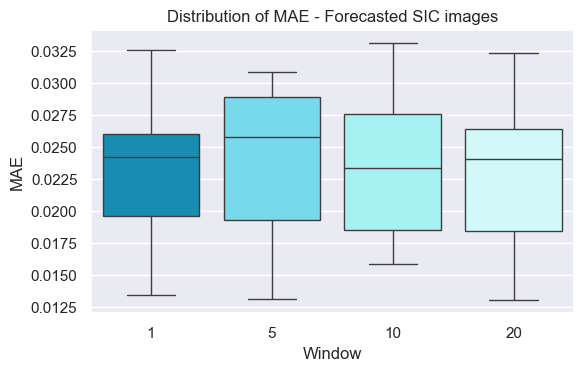

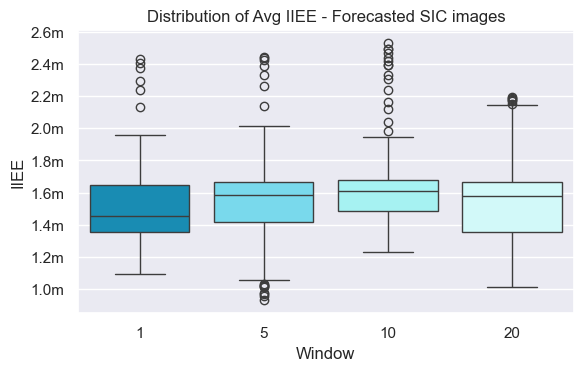

In [ ]:
if run_climate_avg_on_latent or run_img_climate_avg:
    query_boxplot_lstm( "MAE", lstm_MAE_df,"Distribution of MAE - Forecasted SIC images" , input_df2= climate_MAE_df)
    query_boxplot_lstm( "IIEE", lstm_IIEE_df,"Distribution of Avg IIEE - Forecasted SIC images", yxformat = formatter_mil, input_df2= climate_IIEE_df)
else:
    query_boxplot_lstm( "MAE", lstm_MAE_df,"Distribution of MAE - Forecasted SIC images")
    query_boxplot_lstm( "IIEE", lstm_IIEE_df,"Distribution of Avg IIEE - Forecasted SIC images", yxformat = formatter_mil)

In [ ]:
def melf_frame_lineplot(input_mae,input_iiee, qry):
    
    var = input_mae.columns[0]

    temp_df = input_mae.query(qry)
    temp_df2 = input_iiee.query(qry)

    temp_df = temp_df.melt(var, var_name = 'pred_day',value_name = 'MAE' )
    temp_df['pred_day'] = temp_df['pred_day']-1

    temp2_df = temp_df2.melt(var, var_name = 'pred_day',value_name = 'IIEE' )
    temp2_df['pred_day'] = temp2_df['pred_day']-1

    return temp_df, temp2_df

In [ ]:
melted_dfs = []
title_list = []

var = lstm_MAE_df.columns[0]

for i in windows:

    input_qry = '{} == {}'.format(var,i)
    out_df1, out_df2 = melf_frame_lineplot(lstm_MAE_df, lstm_IIEE_df, input_qry)
    melted_dfs.append(out_df1)
    melted_dfs.append(out_df2)
    
    if i == 1:
        temp_title = "No moving average".format(i)
    else:
        temp_title = "{}-day moving average window".format(i)
    title_list.append(temp_title)

In [ ]:
if run_climate_avg_on_latent or run_img_climate_avg:
    c_melted_dfs = []
    c_title_list = []

    var = climate_MAE_df.columns[0]

    for i in windows:

        input_qry = '{} == {}'.format(var,i)
        out_df1, out_df2 = melf_frame_lineplot(climate_MAE_df, climate_IIEE_df, input_qry)
        c_melted_dfs.append(out_df1)
        c_melted_dfs.append(out_df2)
        
        if i == 1:
            temp_title = "No moving average".format(i)
        else:
            temp_title = "{}-year climatology average".format(i)
        c_title_list.append(temp_title)

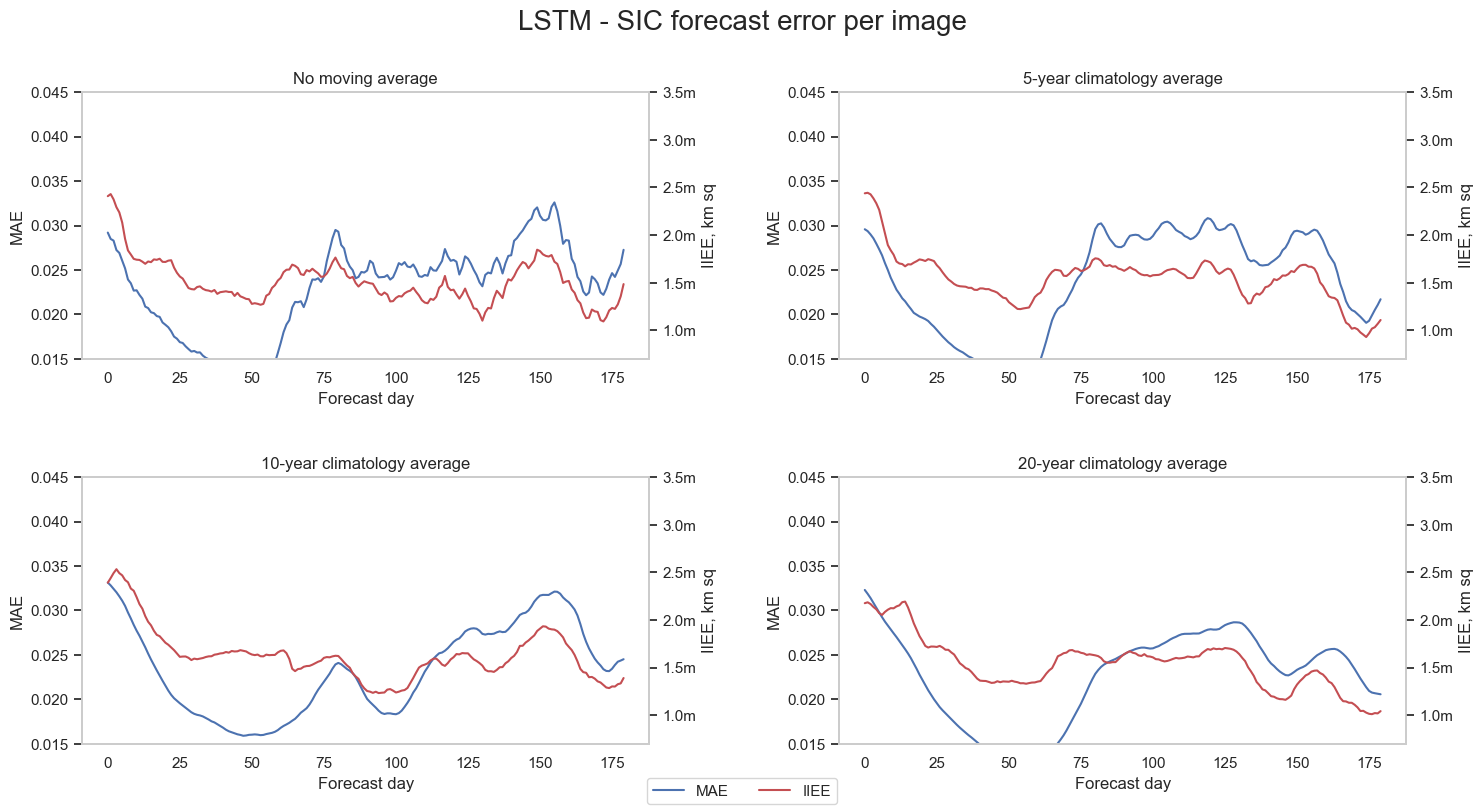

In [ ]:
import seaborn as sns

sns.set(style="whitegrid")
if run_climate_avg_on_latent or run_img_climate_avg:
    fig, axs = plt.subplots(3, 2, figsize=(15, 12))
else:
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))

ax1 = sns.lineplot(melted_dfs[0], x='pred_day', y = 'MAE', label ='MAE', ax =axs[0][0] )
ax1.grid(False)
ax1.set(xlabel='Forecast day')
#ax1.set_ylim([0.01, 0.04])
ax1.set_ylim([0.015, 0.045])
ax1.title.set_text(title_list[0])


ax2 = axs[0][0].twinx()
sns.lineplot(data=melted_dfs[1], x='pred_day', y = 'IIEE',color="r", ax=ax2, label ='IIEE')
ax2.yaxis.set_major_formatter(formatter_mil)
ax2.grid(False)
ax2.set(ylabel='IIEE, km sq')
ax2.set_ylim([0.7e6, 3.5e6])

##################################

ax3 = sns.lineplot(melted_dfs[2], x='pred_day', y = 'MAE', label ='_MAE', ax =axs[0][1] )
ax3.grid(False)
ax3.set(xlabel='Forecast day')
#ax3.set_ylim([0.01, 0.04])
ax3.set_ylim([0.015, 0.045])
ax3.title.set_text(title_list[1])

ax4 = axs[0][1].twinx()
sns.lineplot(data=melted_dfs[3], x='pred_day', y = 'IIEE',color="r", ax=ax4, label ='_IIEE')
ax4.yaxis.set_major_formatter(formatter_mil)
ax4.grid(False)
ax4.set(ylabel='IIEE, km sq')
ax4.set_ylim([0.7e6, 3.5e6])

################################################
ax5 = sns.lineplot(melted_dfs[4], x='pred_day', y = 'MAE', label ='_MAE', ax =axs[1][0] )
ax5.grid(False)
ax5.set(xlabel='Forecast day')
#ax5.set_ylim([0.01, 0.04])
ax5.set_ylim([0.015, 0.045])
ax5.title.set_text(title_list[2])

ax6 = axs[1][0].twinx()
sns.lineplot(data=melted_dfs[5], x='pred_day', y = 'IIEE',color="r", ax=ax6, label ='_IIEE')
ax6.yaxis.set_major_formatter(formatter_mil)
ax6.grid(False)
ax6.set(ylabel='IIEE, km sq')
ax6.set_ylim([0.7e6, 3.5e6])

####################################################

ax7 = sns.lineplot(melted_dfs[6], x='pred_day', y = 'MAE', label ='_MAE', ax =axs[1][1] )
ax7.grid(False)
ax7.set(xlabel='Forecast day')
#ax7.set_ylim([0.01, 0.04])
ax7.set_ylim([0.015, 0.045])
ax7.title.set_text(title_list[3])


ax8 = axs[1][1].twinx()
sns.lineplot(data=melted_dfs[7], x='pred_day', y = 'IIEE',color="r", ax=ax8, label ='_IIEE')
ax8.yaxis.set_major_formatter(formatter_mil)
ax8.grid(False)
ax8.set(ylabel='IIEE, km sq')
ax8.set_ylim([0.7e6, 3.5e6])

####################################################

if run_climate_avg_on_latent or run_img_climate_avg:
    ax9 = sns.lineplot(melted_dfs[8], x='pred_day', y = 'MAE', label ='_MAE', ax =axs[2][0] )
    ax9.grid(False)
    ax9.set(xlabel='Forecast day')
    #ax9.set_ylim([0.01, 0.04])
    ax9.set_ylim([0.015, 0.045])
    ax9.title.set_text(title_list[4])


    ax10 = axs[2][0].twinx()
    sns.lineplot(data=melted_dfs[9], x='pred_day', y = 'IIEE',color="r", ax=ax10, label ='_IIEE')
    ax10.yaxis.set_major_formatter(formatter_mil)
    ax10.grid(False)
    ax10.set(ylabel='IIEE, km sq')
    ax10.set_ylim([0.7e6, 3.5e6])

####################################################

    ax11 = sns.lineplot(melted_dfs[10], x='pred_day', y = 'MAE', label ='_MAE', ax =axs[2][1] )
    ax11.grid(False)
    ax11.set(xlabel='Forecast day')
    #ax11.set_ylim([0.01, 0.04])
    ax11.set_ylim([0.015, 0.045])
    ax11.title.set_text(title_list[5])


    ax12 = axs[2][1].twinx()
    sns.lineplot(data=melted_dfs[11], x='pred_day', y = 'IIEE',color="r", ax=ax12, label ='_IIEE')
    ax12.yaxis.set_major_formatter(formatter_mil)
    ax12.grid(False)
    ax12.set(ylabel='IIEE, km sq')
    ax12.set_ylim([0.7e6, 3.5e6])


    cax1 = sns.lineplot(c_melted_dfs[0], x='pred_day', y = 'MAE', label ='c_avg MAE', ax =axs[0][0] )
    cax2 = sns.lineplot(data=c_melted_dfs[1], x='pred_day', y = 'IIEE',color="g", ax=ax2, label ='c_avg IIEE')
    
    cax3 = sns.lineplot(c_melted_dfs[2], x='pred_day', y = 'MAE', label ='_c_avg MAE', ax =axs[0][1] )
    cax4 = sns.lineplot(data=c_melted_dfs[3], x='pred_day', y = 'IIEE',color="g", ax=ax4, label ='_c_avg IIEE')

    cax5 = sns.lineplot(c_melted_dfs[4], x='pred_day', y = 'MAE', label ='_c_avg MAE', ax =axs[1][0] )
    cax6 = sns.lineplot(data=c_melted_dfs[3], x='pred_day', y = 'IIEE',color="g", ax=ax6, label ='_c_avg IIEE')
        
    cax7 = sns.lineplot(c_melted_dfs[6], x='pred_day', y = 'MAE', label ='_c_avg MAE', ax =axs[1][1] )
    cax8 = sns.lineplot(data=c_melted_dfs[7], x='pred_day', y = 'IIEE',color="g", ax=ax8, label ='_c_avg IIEE')

    cax9 = sns.lineplot(c_melted_dfs[8], x='pred_day', y = 'MAE', label ='_c_avg MAE', ax =axs[2][0] )
    cax10 = sns.lineplot(data=c_melted_dfs[9], x='pred_day', y = 'IIEE',color="g", ax=ax10, label ='_c_avg IIEE')

    cax11 = sns.lineplot(c_melted_dfs[10], x='pred_day', y = 'MAE', label ='_c_avg MAE', ax =axs[2][1] )
    cax12 = sns.lineplot(data=c_melted_dfs[11], x='pred_day', y = 'IIEE',color="g", ax=ax12, label ='_c_avg IIEE')

#ax8.legend(loc = 'lower right')

#handles, labels = plt.gca().get_legend_handles_labels()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]

lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.legend(lines, labels, loc="lower center", ncol=4)

#fig.subplots_adjust(hspace=0.1)


if run_climate_avg_on_latent:
    fig.suptitle("LSTM - latent space climatology average - SIC forecast error per image", size = 20, y=1)
elif run_img_climate_avg:
    fig.suptitle("LSTM - image space climatology average - SIC forecast error per image", size = 20, y=1)
else:
    fig.suptitle("LSTM - SIC forecast error per image", size = 20, y=1)


axis_list = [ax1,ax2]

for i in axis_list: i.get_legend().remove()

#ax8.get_legend().remove()
#plt.show()
plt.tight_layout(h_pad=3, w_pad = 3)


In [ ]:
def melt_frame_lineplot_any(input,metric, qry):
    temp_df = input.query(qry)
    var = input.columns[0]
    temp_df = temp_df.melt(var, var_name = 'pred_day',value_name = metric )

    temp_df['pred_day'] = temp_df['pred_day']-1

    return temp_df

In [ ]:
melted_int_dfs = []
title_int_list = []

var = lstm_avg_stat_df.columns[0]

for i in windows:
    #m,n,o = i
    input_qry = '{} == {}'.format(var,i)

    out_df1 = melt_frame_lineplot_any(lstm_true_integral_df,"True" , input_qry)
    out_df2 = melt_frame_lineplot_any(lstm_pred_integral_df,"Pred" , input_qry)
    melted_int_dfs.append(out_df1)
    melted_int_dfs.append(out_df2)
    
    if i == 1:
        temp_title = "No moving average".format(i)
    else:
        temp_title = "{}-year climatology average".format(i)
    title_int_list.append(temp_title)

In [ ]:
if run_climate_avg_on_latent or run_img_climate_avg:
    c_melted_int_dfs = []
    c_title_int_list = []

    var = lstm_avg_stat_df.columns[0]

    for i in windows:
        #m,n,o = i
        input_qry = '{} == {}'.format(var,i)

        out_df1 = melt_frame_lineplot_any(climate_integral_df,"C_avg" , input_qry)
        c_melted_int_dfs.append(out_df1)
        
        if i == 1:
            temp_title = "No moving average".format(i)
        else:
            temp_title = "{}-year climatology average".format(i)
        c_title_int_list.append(temp_title)

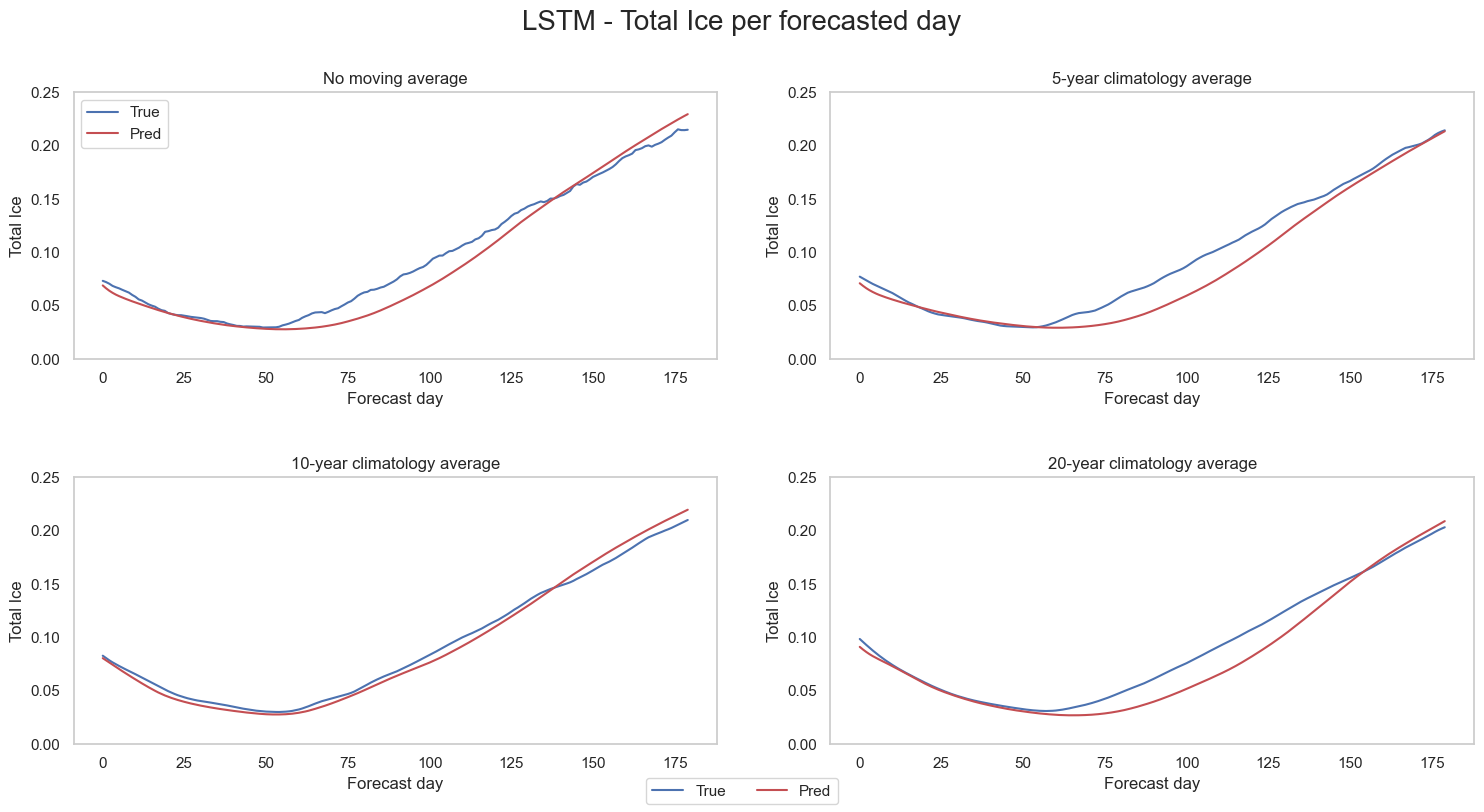

In [ ]:
import seaborn as sns

sns.set(style="whitegrid")

if run_climate_avg_on_latent or run_img_climate_avg:
    fig_int, axs_int = plt.subplots(3, 2, figsize=(15, 12))
else:
    fig_int, axs_int = plt.subplots(2, 2, figsize=(15, 8))

ax1_int = sns.lineplot(melted_int_dfs[0], x='pred_day', y = 'True', label ='True', ax =axs_int[0][0], color="b" )
sns.lineplot(data=melted_int_dfs[1], x='pred_day', y = 'Pred',color="r", ax=axs_int[0][0], label ='Pred')
ax1_int.grid(False)
ax1_int.set(xlabel='Forecast day')
ax1_int.title.set_text(title_int_list[0])
ax1_int.set_ylim([0.0, 0.25])
ax1_int.set(ylabel="Total Ice")

ax2_int = sns.lineplot(melted_int_dfs[2], x='pred_day', y = 'True', label ='_True', ax =axs_int[0][1], color="b" )
sns.lineplot(data=melted_int_dfs[3], x='pred_day', y = 'Pred',color="r", ax=axs_int[0][1], label ='_Pred')
ax2_int.grid(False)
ax2_int.set(xlabel='Forecast day')
ax2_int.title.set_text(title_int_list[1])
ax2_int.set_ylim([0.0, 0.25])
ax2_int.set(ylabel="Total Ice")

ax3_int = sns.lineplot(melted_int_dfs[4], x='pred_day', y = 'True', label ='_True', ax =axs_int[1][0], color="b" )
sns.lineplot(data=melted_int_dfs[5], x='pred_day', y = 'Pred',color="r", ax=axs_int[1][0], label ='_Pred')
ax3_int.grid(False)
ax3_int.set(xlabel='Forecast day')
ax3_int.title.set_text(title_int_list[2])
ax3_int.set_ylim([0.0, 0.25])
ax3_int.set(ylabel="Total Ice")


ax4_int = sns.lineplot(melted_int_dfs[6], x='pred_day', y = 'True', label ='_True', ax =axs_int[1][1], color="b" )
sns.lineplot(data=melted_int_dfs[7], x='pred_day', y = 'Pred',color="r", ax=axs_int[1][1], label ='_Pred')
ax4_int.grid(False)
ax4_int.set(xlabel='Forecast day')
ax4_int.title.set_text(title_int_list[3])
ax4_int.set_ylim([0.0, 0.25])
ax4_int.set(ylabel="Total Ice")

if run_climate_avg_on_latent or run_img_climate_avg:
    ax5_int = sns.lineplot(melted_int_dfs[8], x='pred_day', y = 'True', label ='_True', ax =axs_int[2][0], color="b" )
    sns.lineplot(data=melted_int_dfs[9], x='pred_day', y = 'Pred',color="r", ax=axs_int[2][0], label ='_Pred')
    ax5_int.grid(False)
    ax5_int.set(xlabel='Forecast day')
    ax5_int.title.set_text(title_int_list[4])
    ax5_int.set_ylim([0.0, 0.25])
    ax5_int.set(ylabel="Total Ice")


    ax6_int = sns.lineplot(melted_int_dfs[10], x='pred_day', y = 'True', label ='_True', ax =axs_int[2][1], color="b" )
    sns.lineplot(data=melted_int_dfs[11], x='pred_day', y = 'Pred',color="r", ax=axs_int[2][1], label ='_Pred')
    ax6_int.grid(False)
    ax6_int.set(xlabel='Forecast day')
    ax6_int.title.set_text(title_int_list[5])
    ax6_int.set_ylim([0.0, 0.25])
    ax6_int.set(ylabel="Total Ice")

    sns.lineplot(data=c_melted_int_dfs[0], x='pred_day', y = 'C_avg',color="g", ax=axs_int[0][0], label ='C_avg')
    sns.lineplot(data=c_melted_int_dfs[1], x='pred_day', y = 'C_avg',color="g", ax=axs_int[0][1], label ='_C_avg')
    sns.lineplot(data=c_melted_int_dfs[2], x='pred_day', y = 'C_avg',color="g", ax=axs_int[1][0], label ='_C_avg')
    sns.lineplot(data=c_melted_int_dfs[3], x='pred_day', y = 'C_avg',color="g", ax=axs_int[1][1], label ='_C_avg')
    sns.lineplot(data=c_melted_int_dfs[4], x='pred_day', y = 'C_avg',color="g", ax=axs_int[2][0], label ='_C_avg')
    sns.lineplot(data=c_melted_int_dfs[5], x='pred_day', y = 'C_avg',color="g", ax=axs_int[2][1], label ='_C_avg')

lines_labels = [ax.get_legend_handles_labels() for ax in fig_int.axes]

lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig_int.legend(lines, labels, loc="lower center", ncol=3)

#fig.subplots_adjust(hspace=0.1)
if run_climate_avg_on_latent:
    fig_int.suptitle("LSTM - latent space climatology average - Total Ice per forecasted day", size = 20, y=1)
elif run_img_climate_avg:
    fig_int.suptitle("LSTM - image space climatology average - Total Ice per forecasted day", size = 20, y=1)
else:
    fig_int.suptitle("LSTM - Total Ice per forecasted day", size = 20, y=1)

axis_list = [ax1_int,ax2_int]

#for i in axis_list: i.get_legend().remove()

#ax8.get_legend().remove()
#plt.show()
plt.tight_layout(h_pad=3, w_pad = 3)
